# BM 336027 - Technion - Medical Image Processing


## Homework 3 - Image interpolation, Fourier domain operation and registration.
---

### <a style='color:red'> Due Date: 28.12.2022 </a>

---

### Agenda

* [Exercise 0: Phase and amplitude ](#Exercise-0)
* [Exercise 1: Phase correlation ](#Exercise-1)
* [Exercise 2: Image transformation and interpolation ](#Exercise-2)


#### Use as many cells as you need

---
### Students Information

* Fill in


|              Name |             Id |             email |
|-------------------|----------------|------------------ |
|  [Shahar Rashty] | [312465305] | [rashty@campus.technion.ac.il] |

### Submission Guidelines
---
* **No handwritten submissions.** 
* What you have to submit:
    * You should submit this file only, with the name: `bm_hw3_id.ipynb`.
    * No other file-types (`.py`, `.docx`...) will be accepted.
* Submission on the course website (Moodle).

In [1]:
# imports you will need
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.data import camera, coffee
from typing import Tuple
%matplotlib inline

---

### **Assignment Instructions**
**In this assignment, you are allowed to use only basic numpy functions (including the module `np.fft`) and matplotlib functions, and functions you implemented in other sections of the exercises (unless otherwise instructed)**

---

### Exercise 0

1. In class, you learned about the importance of Fourier transform components. Recreate the figures you saw in class using the two images 'camera' and 'coffee'.<br>
    Load the images by calling the two functions with the same name imported from the skimage.data library. Note that you might need to transform the image from RGB to gray; you may use the function `rgb2gray` of skimage.color library that was imported in the first code block. <br>
    Crop the center of both images to the size 400x400.<br>
    Compute their Fourier transform and create two new images, one whose Fourier transform is made of the frequency magnitudes of the image 'coffee' and the frequency phases of 'camera' and vice versa.<br> 
    Display the images in one figure and add titles.
    

In [2]:
def crop_center(img,cropx,cropy): 
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

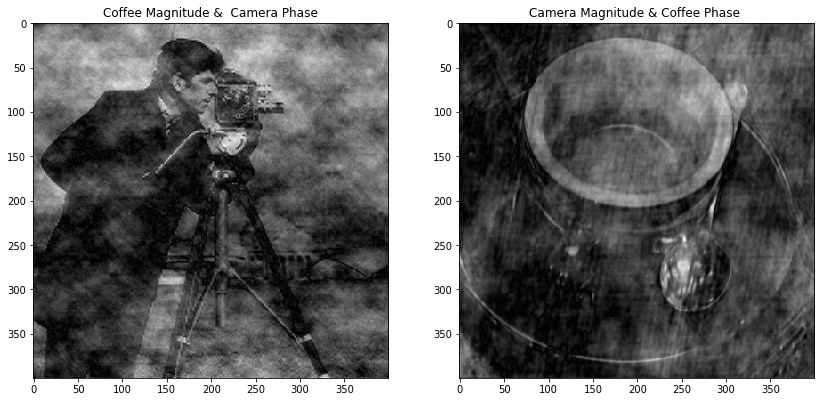

In [3]:
# ====== YOUR CODE: ======
coffee_img = rgb2gray(coffee())
camera_img = rgb2gray(camera())

#crop
coffee_crop = crop_center(coffee_img,400,400)
camera_crop = crop_center(camera_img,400,400)

#transform and shift
coffee_trans = np.fft.fftshift(np.fft.fft2(coffee_crop))
camera_trans = np.fft.fftshift(np.fft.fft2(camera_crop))

#phase and magnitude
coffee_phase = np.angle(coffee_trans)
camera_phase = np.angle(camera_trans)

coffee_mag = np.abs(coffee_trans)
camera_mag = np.abs(camera_trans)

#mixing and inverse transform
img_mix_1 = np.multiply(coffee_mag, np.exp(1j*camera_phase))
img_ifft_1 = np.fft.ifft2(img_mix_1)

img_mix_2 = np.multiply(camera_mag, np.exp(1j*coffee_phase))
img_ifft_2 = np.fft.ifft2(img_mix_2)

#plot
plt.figure(figsize=(14, 8))
plt.subplot(121),plt.imshow(abs(img_ifft_1), cmap= 'gray'), plt.title('Coffee Magnitude &  Camera Phase')
plt.subplot(122),plt.imshow(abs(img_ifft_2), cmap= 'gray'), plt.title('Camera Magnitude & Coffee Phase ')
plt.show()


# ========================   

2.  Create an image whose Fourier transform is made of the frequency magnitude of random values and the frequency phases of one of the images above (camera or coffee). Display the image and add title. 

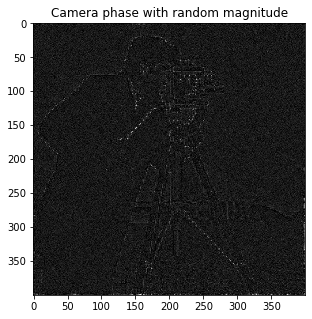

In [4]:
# ====== YOUR CODE: ======
magnitude_random = abs(np.fft.fftshift(np.fft.fft2(np.random.randint(0, 255, (400,400)))))
img_mix_random = np.fft.ifft2(np.multiply(magnitude_random, np.exp(1j*camera_phase)))

plt.figure(figsize=(10, 5))
plt.imshow(abs(img_mix_random),cmap='gray')
plt.title('Camera phase with random magnitude')
plt.show()

# ========================   

---

###  Exercise 1

In this exercise, you will implement a registration algorithm based on the Fourier transform, called phase correlation.<br> 
The phase correlation method is based on the Fourier shift theorem and is used to find the translation between two images.<br>
1. First, we want to get the magnitude and phase of the Fourier transform of the images. Implement the `fft_r_theta` function. The function should compute the FFT transform of the image and return two arrays; the first is the signal magnitude, and the second is the phase. Write a description of your function and explain its inputs and output.  

In [5]:
def fft_r_theta(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''
     
    Compute the FFT transform of the image and return two arrays; the first is the signal magnitude, and the second is the phase.
    
    :param img: input image
    :return r: signal magnitude
    :return theta: signal phase
    '''
    # ====== YOUR CODE: ======
    img_fft = np.fft.fftshift(np.fft.fft2(img))

    #phase and magnitude
    theta = np.angle(img_fft)
    r = np.abs(img_fft)
    
    # ========================
    return r, theta

2. Load the images 'template.png' and 'moving.png' and compute their difference. <br>
    Display in one figure for each image (template, moving and the difference) the original image, its log magnitude and phase of their Fourier transform (3x3 grid of images). Add titles to your images.   

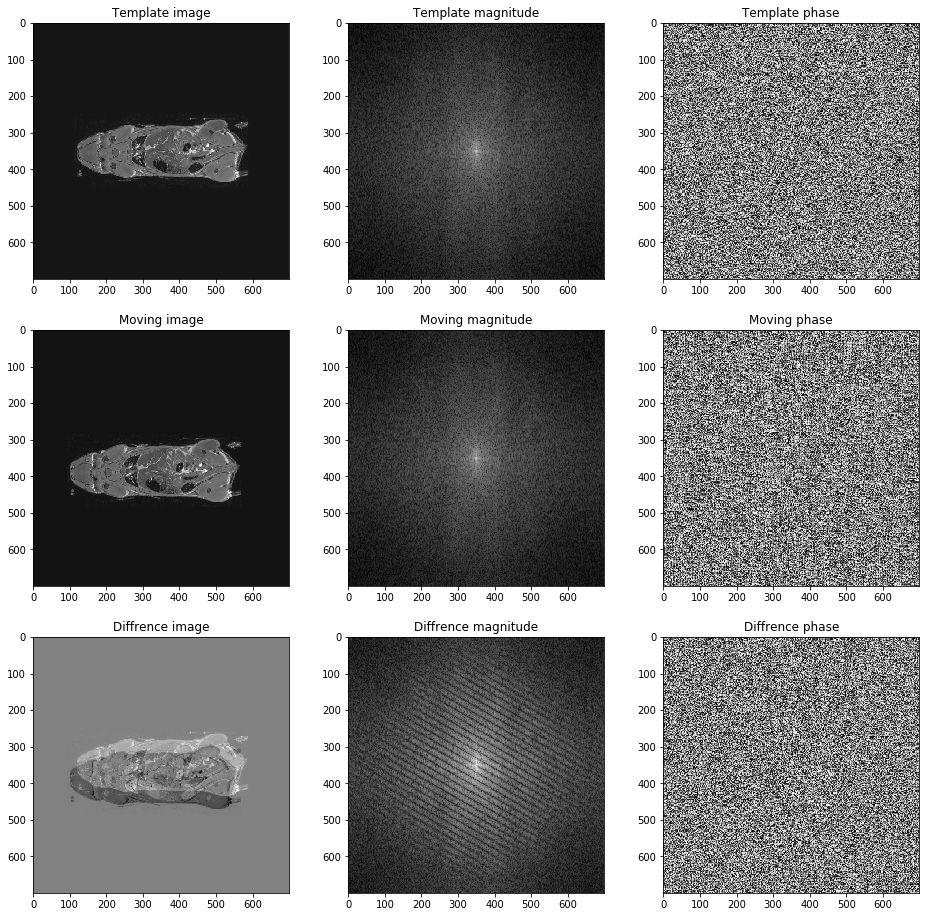

In [6]:
# ====== YOUR CODE: ======
template = plt.imread('template.png')
moving = plt.imread('moving.png')
diff = template - moving

template_mag, template_phase = fft_r_theta(template)
moving_mag, moving_phase = fft_r_theta(moving)
diff_mag, diff_phase = fft_r_theta(diff)

template_mag_shifted = np.log(template_mag+1)
moving_mag_shifted = np.log(moving_mag+1)
diff_mag_shifted = np.log(diff_mag+1)

show = [[template,template_mag_shifted,template_phase,'Template'],[moving,moving_mag_shifted,moving_phase,'Moving'],[diff,diff_mag_shifted,diff_phase,'Diffrence']]


plt.figure(figsize=(16,16))
counter = 1
for lst in show:
        plt.subplot(3,3,counter)
        plt.imshow(lst[0],cmap = "gray")
        plt.title(f"{lst[-1]} image")
        counter += 1
        plt.subplot(3,3,counter)
        plt.imshow(lst[1],cmap = "gray")
        plt.title(f"{lst[-1]} magnitude")
        counter += 1
        plt.subplot(3,3,counter)
        plt.imshow(lst[2],cmap = "gray")
        plt.title(f"{lst[-1]} phase")
        counter += 1

# ========================

Now, we want to find the translation between the two images and the required correction.<br>
Based on the Fourier shift theorem, we can express the images $f_1,f_2$ as follows:
    
$$
f_2(x,y)=f_1(x-t_x,y-t_y)\\
F_2(u,v)=e^{-2j\pi(ut_x+vt_y)}F_1(u,v)
$$

where $t_x, t_y$ represent the translation and $F_1,F_2$ are the Fourier transforms of the images $f_1,f_2$ respectivly.<br> 

The translation between two images $f_1,f_2$ can be found using the normalized cross power spectrum (CPS): 
$$
e^{-2j\pi(ut_x+vt_y)}=\frac{F_1(u,v)F^*_2(u,v)}{|F_1(u,v)F^*_2(u,v)|}
$$
where $F^*_2$ is the complex conjugate of $F_2$


The term $e^{-2j\pi(ut_x+vt_y)}$ is the Fourier transform of the shifted Dirac delta function. Hence, we can calculate $t_x,t_y$ by computing the inverse Fourier transform of the CPS and finding the location of the peak.


2. Implement the function `phase_correlation` that gets two images and returns the translation between them in the x and y axes, and the reconstructed image (the moving image after the required shifting). Write a description of your function and explain its inputs and output.

In [7]:
def phase_correlation(img1: np.ndarray, img2: np.ndarray)-> Tuple[int, int, np.ndarray]:
    '''
    Gets two images and returns the translation between them in the x and y axis, and the reconstructed image
    :param img1: input image 1
    :param img2: input image 2
    :return res_dx: the translation between img1 and img2 in the x axis
    :return res_dy: the translation between img1 and img2 in the y axis
    :return corr_img: the reconstructed image
    '''
    # ====== YOUR CODE: ======
    
    F1 = np.fft.fft2(img1)
    F2 = np.fft.fft2(img2)
    
    F2_star = np.conjugate(F2)
    
    F1_F2star = np.multiply(F1,F2_star)
    CPS = np.divide(F1_F2star,np.abs(F1_F2star))

    delta = np.abs(np.fft.ifft2(CPS))
    res_dx,res_dy = np.argwhere(delta==np.amax(delta))[0][0] , np.argwhere(delta==np.amax(delta))[0][1]

    M,N = img2.shape
    corr_img = np.zeros([M,N])
    #reconstructing the image from img2 by shifting back the translation in x and y
    for row in range(M):
        for col in range(N):
            corr_img[row, col]  = img2[row-res_dx, col-res_dy]
    
    # ======================== 
    return res_dx, res_dy, corr_img

3. Find the translation between the tamplate image and the moving image and the reconstructed image using the  `phase_correlation`.<br>
    Print the translation in the x and y axes and display in one figure the moving image, the reconstructed image and the difference between the template image and the reconstructed image. Add titles.  

The translation in the (x,y) axis is: (665,20)


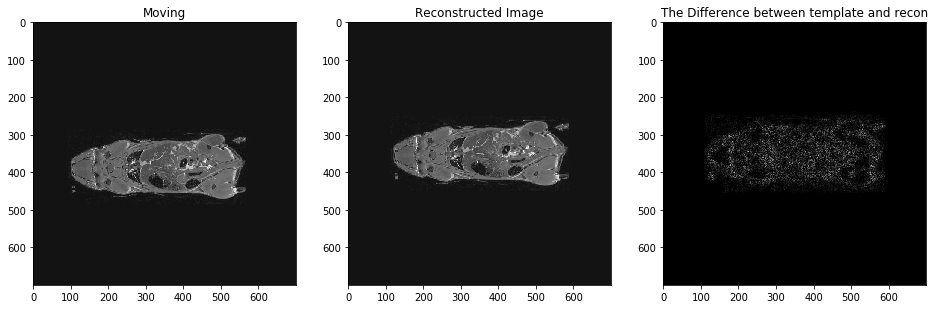

In [8]:
# ====== YOUR CODE: ======
res_dx, res_dy, corr_img = phase_correlation(template,moving)
diff_corr_template = template - corr_img

print(f'The translation in the (x,y) axis is: ({res_dx},{res_dy})')

plt.figure(figsize=(16, 16))
plt.subplot(131),plt.imshow(moving, cmap= 'gray'), plt.title('Moving')
plt.subplot(132),plt.imshow(corr_img, cmap= 'gray'), plt.title('Reconstructed Image')
plt.subplot(133),plt.imshow(np.abs(diff_corr_template) , cmap= 'gray'), plt.title('The Difference between template and recon'),
plt.show()

# ======================== 

4. The peak signal to noise ratio, or PSNR, is a metric of image quality.
$$ PSNR = 20*log_{10}\left(\frac{I_{max}}{\sqrt{\sigma^2}}\right) $$
Where $I_{max}$ is the maximal image value and $\sigma^2$ is the variance of the noise in the image.
The images provided to you have no noise in them. Add normally distributed noise to both images such that the PSNR will be 25. Now use your algorithm on the noisy images (template and moving) and try to match them again.  <br>
Display in one figure the moving image, the reconstructed image and the difference between the template image and the reconstructed image. Add titles.  

In [9]:
def PSNR(img1,img2,psnr):
    #creating the noise based on a given psnr value
    I1 = np.max(img1)
    I2 = np.max(img2)
    sigma1 = I1 / (10**(psnr/20))
    sigma2 = I2 / (10**(psnr/20))
    noise1 = np.random.normal(I1,sigma1,img1.shape) #normal noise with mean of I_max and std calculate for the given psnr
    noise2 = np.random.normal(I2,sigma2,img2.shape)
    
    #adding noise to the images
    img1_noisy = img1+noise1 
    img2_noisy = img2+noise2
    
    #apllying my algoritem on the noisy images
    res_dx, res_dy, corr_img = phase_correlation(img1_noisy,img2_noisy)
    
    #defrence between original image (template) and the reconstructed omage create from noisy images
    diff = img1 - corr_img 
    print(f'The translation in the (x,y) axis is: ({res_dx},{res_dy})')

    plt.figure(figsize=(12, 6))
    plt.subplot(131),plt.imshow(img2, cmap= 'gray'), plt.title('Moving')
    plt.subplot(132),plt.imshow(corr_img, cmap= 'gray'), plt.title('Reconstructed from the noisy image')
    plt.subplot(133),plt.imshow(np.abs(diff) , cmap= 'gray'), plt.title('The Difference'),
    plt.tight_layout()
    plt.show()
    

The translation in the (x,y) axis is: (665,20)


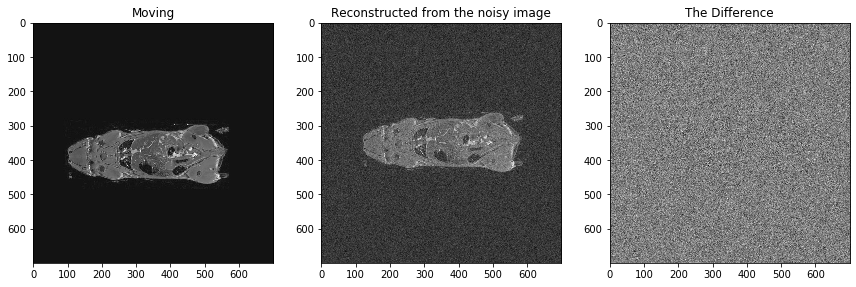

In [10]:
# ====== YOUR CODE: ======
PSNR(template,moving,25)
# ======================== 

5. Repeat the previous task for different levels of PSNR until you find the lowest PSNR for which your algorithm works.

PSNR = 20
The translation in the (x,y) axis is: (665,20)


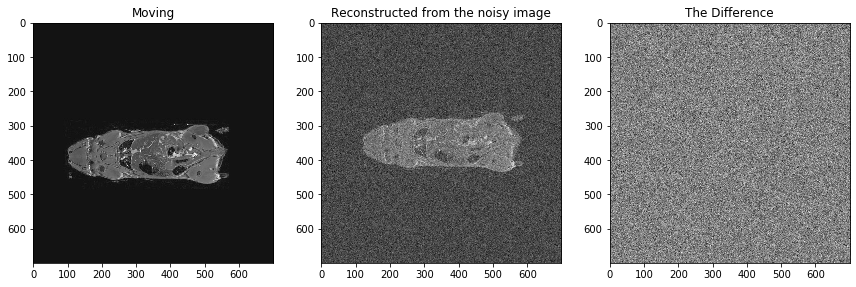

PSNR = 16
The translation in the (x,y) axis is: (665,20)


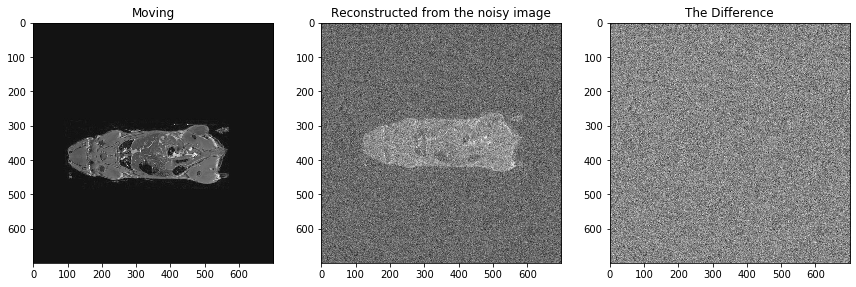

PSNR = 12
The translation in the (x,y) axis is: (665,21)


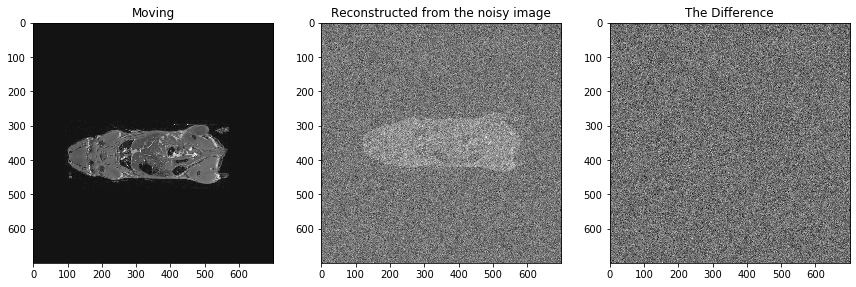

PSNR = 8
The translation in the (x,y) axis is: (665,19)


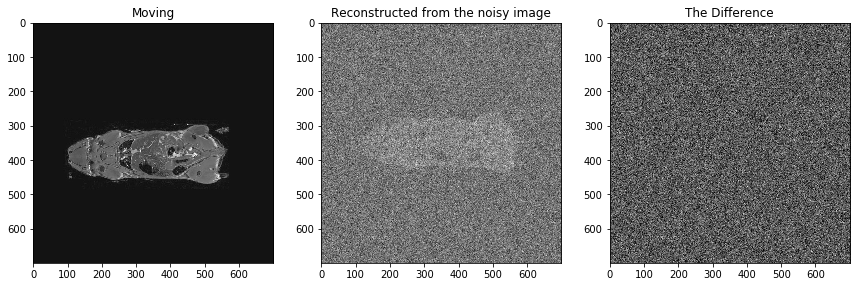

PSNR = 4
The translation in the (x,y) axis is: (513,244)


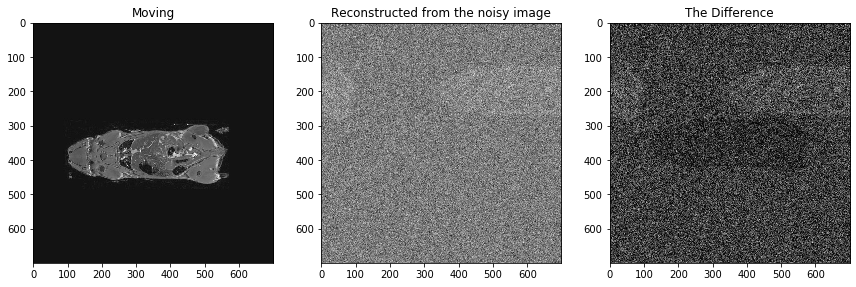

In [11]:
# ====== YOUR CODE: ======
psnrs = list(range(20,3,-4))
# psnrs = list(range(16,5,-2))

for val in psnrs:
    print(f'PSNR = {val}')
    PSNR(template,moving,val)
# ========================

### We can see that for PSNR greater than 12  the correct translation was received and most of the details  can be seen at the reconstructed image.for PSNR that equals 10 or less than 10 we get wrong translation and the reconstructed image is mostly noise. 

---

### Exercise 2

In this exercise, you will implement image transformations and pixel value interpolation.<br>
1. Implement the function `back_project` that recieves a 3x3 transformation matrix (source to destination) and a destination image size as a tuple $(h, w)$ and returns the coordinates of the transformed destination pixels in the source image $(h, w, 2)$.   
Write a description of your function and explain its inputs and output.

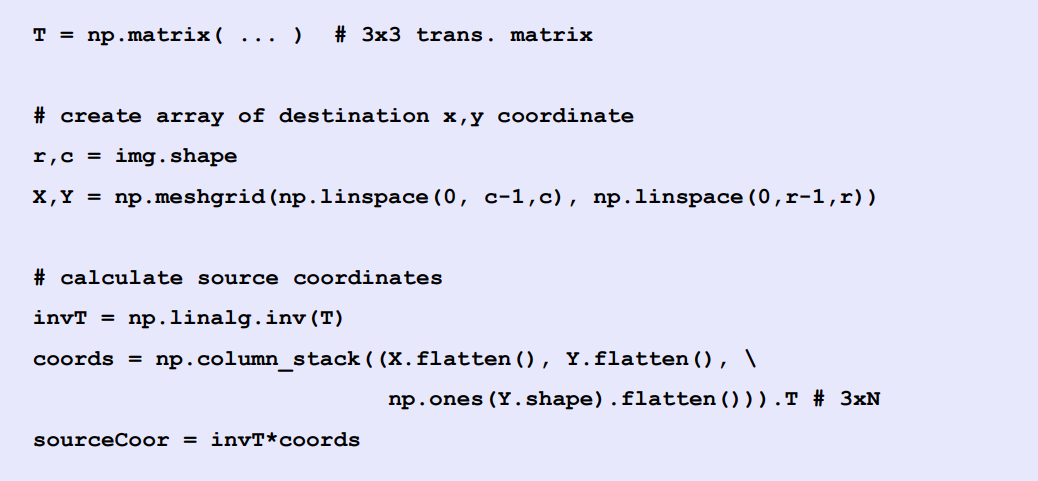

In [12]:
def back_project(mapping: np.ndarray, size: tuple) -> np.ndarray:
    '''
    recieves a 3x3 transformation matrix and a destination image size and returns the coordinates
    of the transformed destination pixels in the source image
    
    :param mapping: 3x3 transformation matrix (source to destination)
    :param size: destination image size as a tuple  (ℎ,𝑤) 
    :return source_coords: the coordinates of the transformed destination pixels in the source image  (ℎ,𝑤,2) .
    '''
    # ====== YOUR CODE: ======
    r,c = size
    X,Y = np.meshgrid(np.linspace(0,c-1,c),np.linspace(0,r-1,r))
    invT = np.linalg.inv(mapping)
    coords = np.column_stack((X.flatten(),Y.flatten(),np.ones(Y.shape).flatten())).T #3xN

    source_coords = np.zeros([r,c,2])
    temp = (invT@coords)[:2,:] #droped the thired row (the ones row)
    source_coords[:,:,0] = np.reshape(temp[0,:],(r,c))
    source_coords[:,:,1] = np.reshape(temp[1,:],(r,c))
   
    # ========================
    return source_coords

2. Implement the function `general_rotation_matrix` that recieves a rotation angle and the center of rotations and creates a transformation for a rotation about the given center (y, x).    
Write a description of your function and explain its inputs and output.

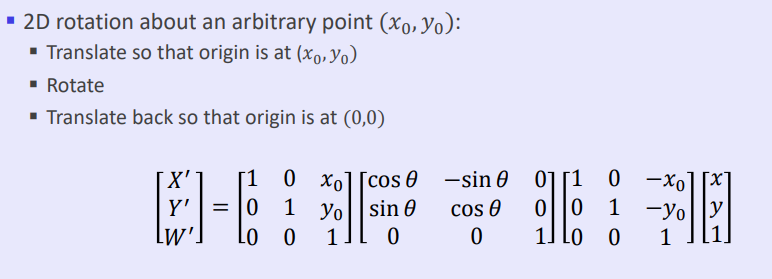

In [13]:
def general_rotation_matrix(degrees: np.ndarray, center: np.ndarray) -> np.ndarray:
    '''
    Thr function  recieves a rotation angle and the center of rotations and creates a transformation for a rotation about the given center (y, x).
    :param degrees: rotation angle
    :param center: center of rotations
    :return rotate_mat: a transformation for a rotation of degrees about the given center (x, y)
    '''
    # ====== YOUR CODE: ======
    x,y = center
    rads = degrees/180*np.pi
    translate_1 = np.array([[1, 0, -x], [0, 1, -y], [0, 0, 1]])
    rotate = np.array([[np.cos(rads), -np.sin(rads), 0], [np.sin(rads), np.cos(rads), 0], [0, 0, 1]])
    translate_2 = np.array([[1, 0, x], [0, 1, y], [0, 0, 1]])
    
    rotate_mat = translate_2 @ rotate @ translate_1
    # ========================
    return rotate_mat

3. Now that we have the positions of the transformed pixels in the source image, we can compute their values using interpolation.<br>
Implement the function `bilinear_interpolation` that receives the source image and an array with the shape $[h, w, 2]$ that contains the subpixel coordinates of the transformed pixels and computes their values using bilinear interpolation.<br>
Write a description of your function and explain its inputs and output.

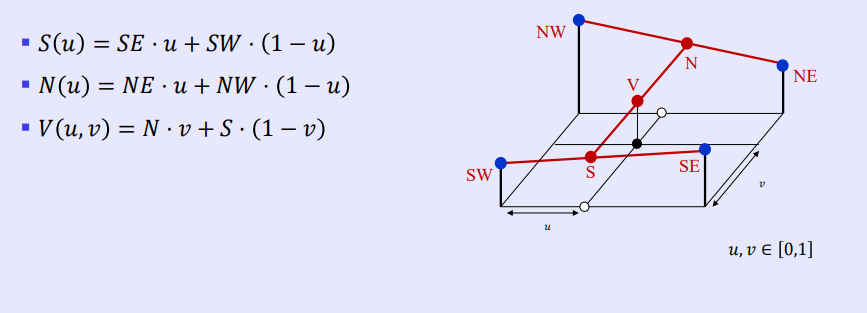

In [14]:
def bilinear_interpolation(source: np.ndarray, coords: np.ndarray) -> np.ndarray:
    '''
    the function receives the source image and an array with the shape  [ℎ,𝑤,2]  that contains the subpixel coordinates of the transformed pixels
    and computes their values using bilinear interpolation.
    
    :param source: source image
    :param coords:  array with the shape  [ℎ,𝑤,2]  that contains the subpixel coordinates of the transformed pixels
    :return interpolation: values of target image that were calculated with bilinear interpolation
    '''
    # ====== YOUR CODE: ======
    height,width = source.shape
    interpolation = np.zeros([height,width])
    
    for w in range(width):
        for h in range(height): 
            x = coords[h,w,0]
            y = coords[h,w,1]
            
            if ((0 <= x < width-1) and (0 <= y < height-1)):
                x0,y0 = int(np.floor(x)) , int(np.floor(y))
                x1,y1 = int(np.ceil(x)) , int(np.ceil(y))

                SW = ( y0, x0 )
                SE = ( y0, x1 )
                NW = ( y1, x0 )
                NE = ( y1, x1 )
                
                u = x - SW[1]
                v = y - SE[0]
                
                S = source[SE]*u + source[SW]*(1-u)
                N = source[NE]*u + source[NW]*(1-u)
                V = N*v + S*(1-v)

                interpolation[h,w] = V
    # ========================        
    return interpolation

Run this block to get an example image from scipy.    
Don't forget to adjust it according to your needs.

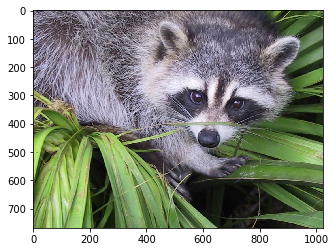

(768, 1024, 3)


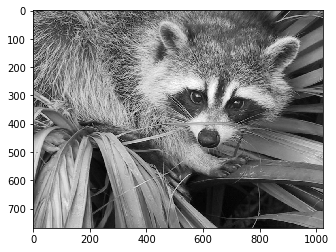

(768, 1024)


In [15]:
from scipy import misc

f= misc.face()
plt.imshow(f,cmap='gray')
plt.show()
print(f.shape)

f = rgb2gray(f)
plt.imshow(f,cmap='gray')
plt.show()
print(f.shape)


4. Use your functions to create 4 different rotation matrices (4 different angles and 3 different rotation canters).    
Plot the image rotated using each rotation matrix.   
Add a title to each figure specifying the rotation angle and the center of rotation.

In [16]:
# ====== YOUR CODE: ======
img_shape = f.shape
mat1=general_rotation_matrix(30,[768//2,1024//2])
mat2=general_rotation_matrix(20,[200,400])
mat3=general_rotation_matrix(70,[800,400])
mat4=general_rotation_matrix(45,[800,400])

coords1 = back_project(mat1, img_shape)
coords2 = back_project(mat2, img_shape)
coords3 = back_project(mat3, img_shape)
coords4 = back_project(mat4, img_shape)

interpolation1 = bilinear_interpolation(f,coords1)
interpolation2 = bilinear_interpolation(f,coords2)
interpolation3 = bilinear_interpolation(f,coords3)
interpolation4 = bilinear_interpolation(f,coords4)

# ======================== 

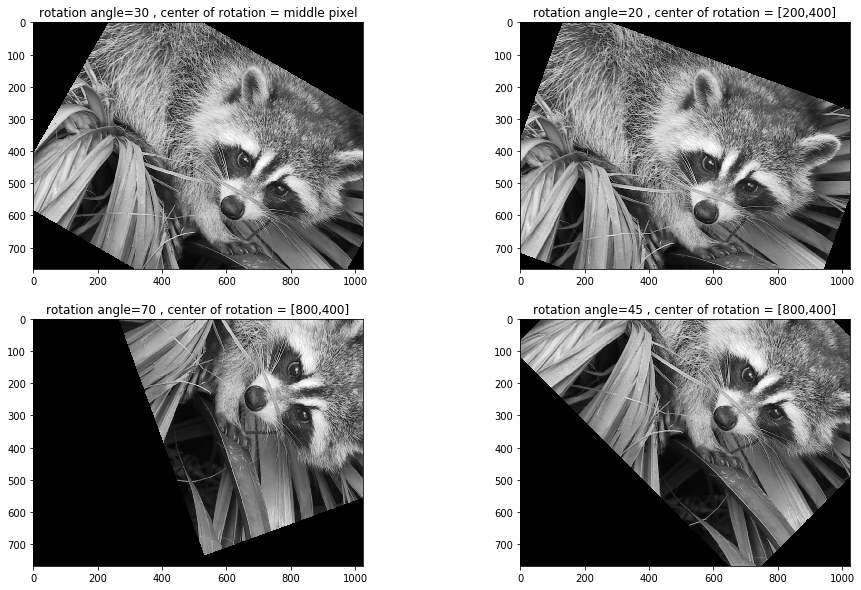

In [17]:
plt.figure(figsize=(16, 10))
plt.subplot(221);plt.imshow(interpolation1,cmap='gray');plt.title('rotation angle=30 , center of rotation = middle pixel')
plt.subplot(222);plt.imshow(interpolation2,cmap='gray');plt.title('rotation angle=20 , center of rotation = [200,400]')
plt.subplot(223);plt.imshow(interpolation3,cmap='gray');plt.title('rotation angle=70 , center of rotation = [800,400]')
plt.subplot(224);plt.imshow(interpolation4,cmap='gray');plt.title('rotation angle=45 , center of rotation = [800,400]')
plt.show()

**Questions:**

5. After applying a sequence of basic affine transformations on the left image, we received the right image. Which affine transformations were applied, and in what order? Write the matrix representation of the transformations.  

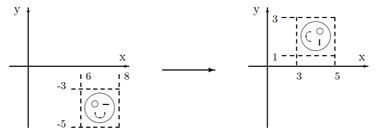   





**Answer:**

The image was rotated by -90 degrees around (7,-4) and then translated by -3 in x axis and +6 on the Y axis!
another option is that the image was translated frist and then rotated by -90 degrees around the new center of the image- around (4,2)


$$\begin{bmatrix} X' \\ Y'  \\ W' \end{bmatrix} =\begin{bmatrix} 1 & 0 & -3 \\ 0 & 1 & 6 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} 1 & 0 & 7 \\ 0 & 1 & -4 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} cos(-90) & -sin(-90) & 0 \\ sin(-90) & cos(-90) & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} 1 & 0 & -7 \\ 0 & 1 & 4 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x  \\ y \\ 1 \end{bmatrix} 
$$


6. To rotate the original image (1), we used nearest neighbor interpolation and bilinear linear interpolation (images 2,3). What interpolation was used in each image (2,3). Explain how you reached that conclusion.      
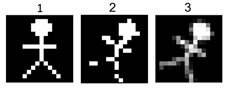    


**Answer:**

Image 1 contains only black and white values , so image 3 must be from bilinear interpolation - because it's has 'new' values ,different gray values, that was'nt at the original image.
image 2 was created with nearest neighboor interpolation - the assign value is taken from the pixel closest to the generated location - we got only black and white values same as the original image. 